In [4]:
import pandas as pd
import os
import time
import random

# Cargar las conversaciones etiquetadas
print("Cargando conversaciones etiquetadas...")
labeled_conversations = []
labeled_conversation_files = os.listdir('labeled_conversations')
# Take just the conversations which haver conversation_0 
labeled_conversation_files = [file for file in labeled_conversation_files if 'conversation_0' in file]
labeled_conversation_files.sort()  # Ordenar los archivos para mantener el orden
print(f"Archivos de conversaciones etiquetadas encontrados: {labeled_conversation_files}")
for file in labeled_conversation_files:
    conversation_df = pd.read_json(f'labeled_conversations/{file}')
    label = int(file.split('_')[-1].split('.')[0])  # Extraer etiqueta de fiebre
    labeled_conversations.append((conversation_df, label))
print(f"Total de conversaciones cargadas: {len(labeled_conversations)}")

Cargando conversaciones etiquetadas...
Archivos de conversaciones etiquetadas encontrados: ['phone_id_10019_conversation_0_label_0.json', 'phone_id_1005_conversation_0_label_-1.json', 'phone_id_10076_conversation_0_label_-1.json', 'phone_id_10085_conversation_0_label_-1.json', 'phone_id_10126_conversation_0_label_-1.json', 'phone_id_10126_conversation_0_label_0.json', 'phone_id_10137_conversation_0_label_-1.json', 'phone_id_10156_conversation_0_label_-1.json', 'phone_id_10218_conversation_0_label_-1.json', 'phone_id_10364_conversation_0_label_0.json', 'phone_id_10685_conversation_0_label_-1.json', 'phone_id_10712_conversation_0_label_0.json', 'phone_id_10934_conversation_0_label_-1.json', 'phone_id_10988_conversation_0_label_-1.json', 'phone_id_11057_conversation_0_label_-1.json', 'phone_id_11143_conversation_0_label_-1.json', 'phone_id_11275_conversation_0_label_0.json', 'phone_id_11321_conversation_0_label_-1.json', 'phone_id_11777_conversation_0_label_-1.json', 'phone_id_12098_conve

In [3]:
# Función para agrupar mensajes consecutivos del usuario en una pregunta coherente
def group_user_messages(conversation, time_threshold=60*5):
    """Agrupa mensajes consecutivos del usuario en bloques de preguntas."""
    grouped_messages = []
    current_question = []
    last_timestamp = None
    
    for _, row in conversation.iterrows():
        created_at = pd.to_datetime(row['created_at'])
        origin = row['origin']
        message = row['message']
        
        if origin == 'client':
            if not last_timestamp or (created_at - last_timestamp).total_seconds() <= time_threshold:
                current_question.append(message)
            else:
                if current_question:
                    grouped_messages.append(" ".join(current_question))
                current_question = [message]
            last_timestamp = created_at

        elif origin == 'agent':
            # Break the loop if the first doctor response is found
            break

    if current_question:
        grouped_messages.append(" ".join(current_question))
    
    return grouped_messages

# Función para detectar la primera respuesta del pediatra
def get_first_doctor_response(conversation, time_threshold=90):
    """Encuentra el primer bloque de respuesta del pediatra."""
    response_block = []
    found_response = False
    last_timestamp = None
    
    for _, row in conversation.iterrows():
        created_at = pd.to_datetime(row['created_at'])
        origin = row['origin']
        message = row['message']
        
        if origin == 'agent':
            if not found_response:
                response_block.append(message)
                found_response = True
            elif (created_at - last_timestamp).total_seconds() <= time_threshold:
                response_block.append(message)
            else:
                break
            last_timestamp = created_at
    
    return " ".join(response_block) if response_block else None

# Función para procesar cada conversación de manera interactiva
def debug_conversations(labeled_conversations, sample_size=5):
    """Muestra conversaciones una por una y permite analizar heurísticas en tiempo real."""
    sample_conversations = random.sample([conv for conv in labeled_conversations if conv[1] == 1], sample_size)
    for conversation, label in sample_conversations:
        print("\n" + "="*40)
        print(f"📌 Procesando nueva conversación (Etiqueta: {label})")
        print("="*40 + "\n")
        
        # Ordenar por timestamp y filtrar eventos del sistema
        conversation = conversation.sort_values(by='created_at')
        conversation = conversation[~conversation['type_message'].isin(['event', 'note'])]
        
        # Reemplazar None por 'image o video' en el campo message --VERIFICAR QUE ESTO sea correcto con los datos crudos
        conversation['message'] = conversation['message'].apply(lambda x: 'image o video' if x is None else x)
        
        # Mostrar la conversación completa
        for _, row in conversation.iterrows():
            print(f"[{row['created_at']}] ({row['origin']}): {row['message']}")
        
        print("\n--- Aplicando heurísticas ---\n")
        
        # Extraer la primera pregunta y su respuesta
        first_question = group_user_messages(conversation)
        first_response = get_first_doctor_response(conversation)
        
        # Mostrar resultados
        print("📍 Pregunta detectada:")
        print(first_question[0] if first_question else "❌ No se encontró pregunta")
        print("\n📍 Respuesta detectada:")
        print(first_response if first_response else "❌ No se encontró respuesta")
        
        input("🔍 Presiona ENTER para continuar con la siguiente conversación...")
        time.sleep(1)

# Ejecutar la depuración interactiva
debug_conversations(labeled_conversations)



📌 Procesando nueva conversación (Etiqueta: 1)

[2024-12-30 04:20:38.354000] (client): Dra buenas noches
[2024-12-30 04:21:40.424000] (client): Mi hija Gabriela de 3 años arranco con fiebre hoy a las 10:30am. 38.6 y esta viniendo cada 4h. Luego a las 2:30 nuevamente 38.6
[2024-12-30 04:22:32.671000] (client): He dado dolex pero la fiebre a las 6:30 no bajo, se mantuvo en 38-37.9 y di advil.... y en este momento está en 39.3
[2024-12-30 04:23:05.056000] (client): Esta nariz tapada a ratos y a ratos tbien se le descongela la nariz
[2024-12-30 04:23:24.893000] (agent): a que hora diste esa dosis de dolex ?
[2024-12-30 04:23:33.922000] (agent): cuanto pesa gabriela y cuanto diste?
[2024-12-30 04:24:04.146000] (client): La última la di a las 2:30pm de dolez
[2024-12-30 04:24:06.062000] (client): Dolex
[2024-12-30 04:24:20.795000] (client): Luego a las 4h como vi que no bajo pues de fue advil
[2024-12-30 04:24:32.347000] (client): Le di 7.5cc y pesa 16kg
[2024-12-30 04:24:46.357000] (client)

KeyboardInterrupt: 

## Findings of the problem

- Conversación empieza por el pediatra: A veces existe la probabilidad de que el pediatra habla primero. Normalmente puede ser seguimiento, o una conversación separada que cumplió los criterios de separación en el anterior paso.
- Mientras el pediatra está respondiendo, el cliente manda un mensaje: En este caso, es difícil capturar la respuesta del pediatra. No sé cómo podría identificarse esa interrupción y eliminarla. 

Igual me gusta como está quedando. Por lo menos tener un par pregunta respuesta con cada conversación, podría ser un avance grande. 

## Ideas para mejorar

- Separar las conversaciones mejor, intentando poner un label de seguimiento. Así podemos evadir el problema de que el pediatra hable primero.
- Si logramos tener algo bueno, se podría empezar a hacer labels de fiebre + tos, fiebre + diarrea, fiebre + vómito, etc, usando LDA. Esto podría ser útil para empezar a identificar diferentes diagnósticos. 


In [ ]:
import pandas as pd
import random
import time
import re

def is_agent_greeting(message: str) -> bool:
    """
    Detecta si un mensaje del pediatra corresponde a un saludo o presentación.
    Se utiliza una lista de expresiones típicas.
    """
    if not message:
        return False
    # Convertir a minúsculas y normalizar
    msg = message.lower().strip()
    # Lista de palabras o frases que indican saludo o presentación
    greeting_patterns = [
        r'\bhola\b',
        r'\bbuenos ?d[ií]as\b',
        r'\bbuenas ?tardes\b',
        r'\bbuenas ?noches\b',
        r'\bte habla\b',
        r'\bsoy\b',
        r'\bcu[ée]ntame\b',
        r'\bienvenido\b',
        r'\bcomo te puedo ayudar\b'
    ]
    for pattern in greeting_patterns:
        if re.search(pattern, msg):
            return True
    return False

def group_user_messages_improved(conversation: pd.DataFrame, time_threshold: int = 60*5) -> list:
    """
    Agrupa mensajes consecutivos del cliente en bloques de preguntas, 
    ignorando mensajes iniciales del pediatra que sean saludos o presentaciones.
    Se asume que la conversación ya está ordenada cronológicamente.
    """
    grouped_messages = []
    current_question = []
    last_timestamp = None
    client_started = False  # Indica si ya apareció un mensaje del cliente

    for _, row in conversation.iterrows():
        created_at = pd.to_datetime(row['created_at'])
        origin = row['origin']
        message = row['message']

        if origin == 'client':
            client_started = True
            # Si es el primer mensaje o el tiempo entre mensajes es menor al umbral, agrupar.
            if last_timestamp is None or (created_at - last_timestamp).total_seconds() <= time_threshold:
                current_question.append(message)
            else:
                # Si se rompe el umbral de tiempo, finalizar el bloque actual
                if current_question:
                    grouped_messages.append(" ".join(current_question))
                current_question = [message]
            last_timestamp = created_at

        elif origin == 'agent':
            # Si aún no ha iniciado el cliente, se asume que estos mensajes son saludos o presentaciones y se ignoran.
            if not client_started:
                if is_agent_greeting(message):
                    continue
                else:
                    # Caso atípico: agente envía mensaje no saludo antes de que el cliente inicie;
                    # se ignora hasta que aparezca un mensaje del cliente.
                    continue
            else:
                # Si ya hubo mensajes del cliente, un mensaje del agente no es parte de la pregunta
                # Salir del bucle, pues se asume que la respuesta ya inició.
                # También se podría evaluar si el mensaje del agente es un saludo de cortesía (para no cortar),
                # pero en este caso, al haber tenido intervención del pediatra, consideramos que la pregunta finalizó.
                break

    if current_question:
        grouped_messages.append(" ".join(current_question))
    
    return grouped_messages

def get_first_doctor_response_improved(conversation: pd.DataFrame, time_threshold: int = 90) -> str:
    """
    Extrae el primer bloque de respuesta relevante del pediatra,
    saltándose mensajes iniciales que sean solo saludos o presentaciones.
    Agrupa mensajes consecutivos del agente que estén a menos de 'time_threshold' segundos.
    """
    response_block = []
    found_response = False
    last_timestamp = None

    for _, row in conversation.iterrows():
        created_at = pd.to_datetime(row['created_at'])
        origin = row['origin']
        message = row['message']

        if origin == 'agent':
            # Saltar saludos o presentaciones si aún no se encontró una respuesta relevante
            if not found_response and is_agent_greeting(message):
                continue
            # Si no se ha iniciado el bloque de respuesta, iniciar con este mensaje
            if not found_response:
                response_block.append(message)
                found_response = True
            # Si ya se inició, evaluar el umbral de tiempo para agrupar mensajes adicionales
            elif last_timestamp and (created_at - last_timestamp).total_seconds() <= time_threshold:
                response_block.append(message)
            else:
                break  # Si se supera el umbral, se considera que el bloque de respuesta finalizó
            last_timestamp = created_at

        elif origin == 'client':
            # Si aparece un mensaje del cliente después de iniciar la respuesta,
            # se entiende que la respuesta del agente ha terminado.
            if found_response:
                break

    return " ".join(response_block) if response_block else None

def debug_conversations_improved(labeled_conversations, sample_size=5):
    """
    Función interactiva para depurar y visualizar la extracción de pares pregunta-respuesta
    utilizando las nuevas heurísticas.
    Se muestra la conversación completa y, a continuación, la pregunta y la respuesta detectadas.
    """
    # Seleccionar aleatoriamente un subconjunto de conversaciones etiquetadas (por ejemplo, etiqueta 1)
    sample_conversations = random.sample([conv for conv in labeled_conversations if conv[1] == 1], sample_size)
    
    for conversation, label in sample_conversations:
        print("\n" + "="*40)
        print(f"📌 Procesando nueva conversación (Etiqueta: {label})")
        print("="*40 + "\n")
        
        # Ordenar la conversación por timestamp y filtrar mensajes del sistema
        conversation = conversation.sort_values(by='created_at')
        conversation = conversation[~conversation['type_message'].isin(['event', 'note'])]
        
        # Normalizar el campo 'message', reemplazando valores None por 'image o video'
        conversation['message'] = conversation['message'].apply(lambda x: 'image o video' if pd.isnull(x) else x)
        
        # Mostrar la conversación completa
        for _, row in conversation.iterrows():
            print(f"[{row['created_at']}] ({row['origin']}): {row['message']}")
        
        print("\n--- Aplicando heurísticas mejoradas ---\n")
        
        # Extraer la pregunta del cliente y la respuesta del pediatra
        questions = group_user_messages_improved(conversation)
        response = get_first_doctor_response_improved(conversation)
        
        print("📍 Pregunta detectada:")
        if questions:
            print(questions[0])
        else:
            print("❌ No se encontró pregunta")
        
        print("\n📍 Respuesta detectada:")
        if response:
            print(response)
        else:
            print("❌ No se encontró respuesta")
        
        input("\n🔍 Presiona ENTER para continuar con la siguiente conversación...")
        time.sleep(1)

# Ejemplo de ejecución interactiva:
# Se asume que 'labeled_conversations' es una lista de tuplas (DataFrame, etiqueta)
debug_conversations_improved(labeled_conversations)


## Extract all pairs with context

In [2]:
import pandas as pd
import random
import time
import re
import os
import json

# Función para detectar si un mensaje del agente es un saludo o presentación.
def is_agent_greeting(message: str) -> bool:
    if not message:
        return False
    msg = message.lower().strip()
    greeting_patterns = [
        r'\bhola\b',
        r'\bbuenos ?d[ií]as\b',
        r'\bbuenas ?tardes\b',
        r'\bbuenas ?noches\b',
        r'\bte habla\b',
        r'\bsoy\b',
        r'\bcu[ée]ntame\b',
        r'\bienvenido\b',
        r'\bcomo te puedo ayudar\b'
    ]
    for pattern in greeting_patterns:
        if re.search(pattern, msg):
            return True
    return False

# Función para formatear un mensaje para el contexto (ej: "[timestamp] (origin): message")
def format_message(row: pd.Series) -> str:
    return f"[{row['created_at']}] ({row['origin']}): {row['message']}"

# Función para extraer un bloque de mensajes del cliente (pregunta)
def extract_question_block(conversation: pd.DataFrame, start_index: int, time_threshold: int = 60*5):
    question_msgs = []
    i = start_index
    n = len(conversation)
    # Agregar el primer mensaje del cliente
    question_msgs.append(conversation.iloc[i]['message'])
    i += 1
    while i < n:
        current_row = conversation.iloc[i]
        if current_row['origin'] == 'client':
            prev_time = pd.to_datetime(conversation.iloc[i - 1]['created_at'])
            curr_time = pd.to_datetime(current_row['created_at'])
            if (curr_time - prev_time).total_seconds() <= time_threshold:
                question_msgs.append(current_row['message'])
                i += 1
            else:
                break
        else:
            break
    question_text = " ".join(question_msgs)
    return question_text, i

# Función para extraer un bloque de respuesta del agente
def extract_answer_block(conversation: pd.DataFrame, start_index: int, time_threshold: int = 90):
    answer_msgs = []
    i = start_index
    n = len(conversation)
    first_answer_found = False
    while i < n:
        current_row = conversation.iloc[i]
        if current_row['origin'] == 'agent':
            # Si aún no se ha iniciado la respuesta, se salta si es un saludo
            if not first_answer_found and is_agent_greeting(current_row['message']):
                i += 1
                continue
            # Inicia o continúa la respuesta
            if not first_answer_found:
                first_answer_found = True
                answer_msgs.append(current_row['message'])
                i += 1
            else:
                # Verificar umbral de tiempo respecto al mensaje anterior
                prev_time = pd.to_datetime(conversation.iloc[i - 1]['created_at'])
                curr_time = pd.to_datetime(current_row['created_at'])
                if (curr_time - prev_time).total_seconds() <= time_threshold:
                    answer_msgs.append(current_row['message'])
                    i += 1
                else:
                    break
        else:
            break  # Si se detecta un mensaje del cliente, finaliza el bloque de respuesta
    answer_text = " ".join(answer_msgs) if answer_msgs else None
    return answer_text, i

# Función principal para extraer TODOS los pares pregunta-respuesta de una conversación.
def extract_all_pairs_from_conversation(conversation: pd.DataFrame, conversation_id: str) -> list:
    pairs = []
    n = len(conversation)
    i = 0
    pair_num = 1

    # Preprocesamiento: la conversación ya debe estar ordenada y filtrada
    # Saltar mensajes iniciales del agente (si son saludos)
    while i < n and conversation.iloc[i]['origin'] == 'agent':
        if is_agent_greeting(conversation.iloc[i]['message']):
            i += 1
        else:
            break

    while i < n:
        current_row = conversation.iloc[i]
        if current_row['origin'] == 'client':
            question_start_index = i
            
            # Definir el contexto:
            if pair_num == 1:
                pair_context = "No contexto por ser el primer par de la convesación"
            else:
                # Para los siguientes pares, se usa todo el historial previo hasta el inicio de la pregunta actual.
                context_lines = [format_message(conversation.iloc[j]) for j in range(0, question_start_index)]
                pair_context = "\n".join(context_lines) if context_lines else ""
            
            # Extraer bloque de pregunta
            question_text, i = extract_question_block(conversation, i, time_threshold=60*5)
            
            # Extraer bloque de respuesta (si existe)
            if i < n and conversation.iloc[i]['origin'] == 'agent':
                answer_text, i = extract_answer_block(conversation, i, time_threshold=90)
            else:
                answer_text = None
            
            # Crear diccionario del par
            pair_dict = {
                "conversation_id": conversation_id,
                "pair_number": pair_num,
                "question": question_text,
                "answer": answer_text,
                "context": pair_context
            }
            pairs.append(pair_dict)
            pair_num += 1
        else:
            i += 1  # Si no es del cliente, avanzamos

    return pairs

# Función interactiva para depurar y visualizar los pares extraídos
def debug_pairs_interactively(pairs: list, conversation: pd.DataFrame):
    print("\n----- Conversación Completa -----\n")
    for _, row in conversation.iterrows():
        print(format_message(row))
    print("\n----- Pares Extraídos -----\n")
    for pair in pairs:
        print("-" * 40)
        print(f"Pair {pair['pair_number']} (Conversation ID: {pair['conversation_id']}):")
        print("Pregunta:", pair['question'])
        print("Respuesta:", pair['answer'])
        print("Contexto:")
        print(pair['context'])
        input("\nPresiona ENTER para continuar con el siguiente par...")

# Función para guardar cada par en un archivo JSON en la estructura deseada.
def save_pairs_to_json(pairs: list, root_folder: str):
    for pair in pairs:
        conversation_id = pair["conversation_id"]
        conversation_folder = os.path.join(root_folder, f"conversation_{conversation_id}")
        if not os.path.exists(conversation_folder):
            os.makedirs(conversation_folder)
        file_name = os.path.join(conversation_folder, f"pair_{pair['pair_number']}.json")
        with open(file_name, "w", encoding="utf-8") as f:
            json.dump(pair, f, ensure_ascii=False, indent=4)

# Función para procesar todas las conversaciones y guardar los pares, sin repetir conversaciones ya procesadas.
def process_all_conversations(labeled_conversations: list, root_folder: str):
    for conversation, label in labeled_conversations:
        # Procesamos solo las conversaciones con etiqueta 1
        if label != 1:
            continue
        
        # Se asume que cada conversación tiene un identificador en una columna 'conversation_id'.
        # Si no, se genera uno aleatorio.
        if "conversation_id" in conversation.columns:
            conversation_id = str(conversation.iloc[0]["conversation_id"])
        else:
            conversation_id = str(random.randint(10000, 99999))
        
        conversation_folder = os.path.join(root_folder, f"conversation_{conversation_id}")
        if os.path.exists(conversation_folder):
            print(f"Conversación {conversation_id} ya procesada, se omite.")
            continue
        
        # Preprocesar la conversación: ordenar por 'created_at', filtrar mensajes del sistema y normalizar 'message'
        conversation = conversation.sort_values(by="created_at")
        conversation = conversation[~conversation["type_message"].isin(["event", "note"])]
        conversation["message"] = conversation["message"].apply(lambda x: "image o video" if pd.isnull(x) else x)
        
        # Extraer todos los pares
        pairs = extract_all_pairs_from_conversation(conversation, conversation_id)
        
        # Depuración interactiva
        debug_pairs_interactively(pairs, conversation)
        
        # Guardar los pares en archivos JSON
        save_pairs_to_json(pairs, root_folder)
        print(f"Conversación {conversation_id} procesada y guardada.\n")
        time.sleep(1)
        

# ------------------------------------------------------------------
# Ejemplo de ejecución interactiva:
# Se asume que 'labeled_conversations' es una lista de tuplas (DataFrame, etiqueta)
# Y que 'root_folder' es la ruta a la carpeta raíz donde se guardarán las conversaciones.
# ------------------------------------------------------------------

# Ejemplo de uso:
root_folder = "pairs_extracted_with_context"
process_all_conversations(labeled_conversations, root_folder)


NameError: name 'labeled_conversations' is not defined

## Pendiente en la celda de arriba

- En el contexto está cogiendo el par extraido, hay que seprarlo. 
- En el caso en el que el pediatra empieza la conversación, guardar lo que dice el pediatra como contexto del primer par

## Sistematic extraction

In [ ]:
import pandas as pd
import random
import time
import re
import os
import json

# Función para detectar si un mensaje del agente es un saludo o presentación.
def is_agent_greeting(message: str) -> bool:
    if not message:
        return False
    msg = message.lower().strip()
    greeting_patterns = [
        r'\bhola\b',
        r'\bbuenos ?d[ií]as\b',
        r'\bbuenas ?tardes\b',
        r'\bbuenas ?noches\b',
        r'\bte habla\b',
        r'\bsoy\b',
        r'\bcu[ée]ntame\b',
        r'\bienvenido\b',
        r'\bcomo te puedo ayudar\b'
    ]
    for pattern in greeting_patterns:
        if re.search(pattern, msg):
            return True
    return False

# Función para formatear un mensaje para el contexto (ej: "[timestamp] (origin): message")
def format_message(row: pd.Series) -> str:
    return f"[{row['created_at']}] ({row['origin']}): {row['message']}"

# Función para extraer un bloque de mensajes del cliente (pregunta)
def extract_question_block(conversation: pd.DataFrame, start_index: int, time_threshold: int = 60*5):
    question_msgs = []
    i = start_index
    n = len(conversation)
    # Agregar el primer mensaje del cliente
    question_msgs.append(conversation.iloc[i]['message'])
    i += 1
    while i < n:
        current_row = conversation.iloc[i]
        if current_row['origin'] == 'client':
            prev_time = pd.to_datetime(conversation.iloc[i - 1]['created_at'])
            curr_time = pd.to_datetime(current_row['created_at'])
            if (curr_time - prev_time).total_seconds() <= time_threshold:
                question_msgs.append(current_row['message'])
                i += 1
            else:
                break
        else:
            break
    question_text = " ".join(question_msgs)
    return question_text, i

# Función para extraer un bloque de respuesta del agente
def extract_answer_block(conversation: pd.DataFrame, start_index: int, time_threshold: int = 90):
    answer_msgs = []
    i = start_index
    n = len(conversation)
    first_answer_found = False
    while i < n:
        current_row = conversation.iloc[i]
        if current_row['origin'] == 'agent':
            # Si aún no se ha iniciado la respuesta, se salta si es un saludo
            if not first_answer_found and is_agent_greeting(current_row['message']):
                i += 1
                continue
            # Inicia o continúa la respuesta
            if not first_answer_found:
                first_answer_found = True
                answer_msgs.append(current_row['message'])
                i += 1
            else:
                prev_time = pd.to_datetime(conversation.iloc[i - 1]['created_at'])
                curr_time = pd.to_datetime(current_row['created_at'])
                if (curr_time - prev_time).total_seconds() <= time_threshold:
                    answer_msgs.append(current_row['message'])
                    i += 1
                else:
                    break
        else:
            break  # Finaliza el bloque de respuesta si aparece un mensaje del cliente
    answer_text = " ".join(answer_msgs) if answer_msgs else None
    return answer_text, i

# Función principal para extraer TODOS los pares pregunta-respuesta de una conversación.
def extract_all_pairs_from_conversation(conversation: pd.DataFrame, conversation_id: str) -> list:
    pairs = []
    n = len(conversation)
    i = 0
    pair_num = 1

    # Preprocesamiento: la conversación ya debe estar ordenada y filtrada.
    # Saltar mensajes iniciales del agente (si son saludos)
    while i < n and conversation.iloc[i]['origin'] == 'agent':
        if is_agent_greeting(conversation.iloc[i]['message']):
            i += 1
        else:
            break

    while i < n:
        current_row = conversation.iloc[i]
        if current_row['origin'] == 'client':
            question_start_index = i
            if label != 1:
                continue
            # Definir el contexto:
            if pair_num == 1:
                pair_context = "No contexto por ser el primer par de la convesación"
            else:
                # Para los siguientes pares, se toma el historial completo de mensajes anteriores a la pregunta.
                context_df = conversation.iloc[0:question_start_index]
                pair_context = context_df.to_dict(orient='records')
            
            # Extraer bloque de pregunta
            question_text, i = extract_question_block(conversation, i, time_threshold=60*5)
            
            # Extraer bloque de respuesta (si existe)
            if i < n and conversation.iloc[i]['origin'] == 'agent':
                answer_text, i = extract_answer_block(conversation, i, time_threshold=90)
            else:
                answer_text = None
            
            # Crear diccionario del par
            pair_dict = {
                "conversation_id": conversation_id,
                "pair_number": pair_num,
                "question": question_text,
                "answer": answer_text,
                "context": pair_context
            }
            pairs.append(pair_dict)
            pair_num += 1
        else:
            i += 1  # Avanza si el mensaje no es del cliente

    return pairs

# Función para guardar cada par en un archivo JSON en la estructura deseada.
def save_pairs_to_json(pairs: list, root_folder: str):
    for pair in pairs:
        conversation_id = pair["conversation_id"]
        conversation_folder = os.path.join(root_folder, f"conversation_{conversation_id}")
        if not os.path.exists(conversation_folder):
            os.makedirs(conversation_folder)
        file_name = os.path.join(conversation_folder, f"pair_{pair['pair_number']}.json")
        with open(file_name, "w", encoding="utf-8") as f:
            # Se agrega default=str para convertir objetos no serializables (como Timestamps) a string.
            json.dump(pair, f, ensure_ascii=False, indent=4, default=str)

# Función para procesar todas las conversaciones y guardar los pares,
# imprimiendo mensajes de progreso y evitando procesar conversaciones ya guardadas.
def process_all_conversations(labeled_conversations: list, root_folder: str):
    total_conv = len(labeled_conversations)
    processed_count = 0
    for conversation, label in labeled_conversations:
        if label != 1:
            continue
        # Obtener o generar el identificador de la conversación
        if "conversation_id" in conversation.columns:
            conversation_id = str(conversation.iloc[0]["conversation_id"])
        else:
            conversation_id = str(random.randint(10000, 99999))
        
        conversation_folder = os.path.join(root_folder, f"conversation_{conversation_id}")
        if os.path.exists(conversation_folder):
            print(f"Conversación {conversation_id} ya procesada, se omite.")
            continue
        
        # Preprocesar la conversación: ordenar, filtrar y normalizar mensajes
        conversation = conversation.sort_values(by="created_at")
        conversation = conversation[~conversation["type_message"].isin(["event", "note"])]
        conversation["message"] = conversation["message"].apply(lambda x: "image o video" if pd.isnull(x) else x)
        
        print(f"Procesando conversación {conversation_id}...")
        pairs = extract_all_pairs_from_conversation(conversation, conversation_id)
        print(f" - Se extrajeron {len(pairs)} pares.")
        
        save_pairs_to_json(pairs, root_folder)
        print(f"Conversación {conversation_id} procesada y guardada.\n")
        processed_count += 1
        print(f"Progreso: {processed_count} de {total_conv} conversaciones procesadas.")
        time.sleep(1)

# ------------------------------------------------------------------
# Ejemplo de uso:
# Se asume que 'labeled_conversations' es una lista de tuplas (DataFrame, etiqueta)
# Y que 'root_folder' es la ruta a la carpeta raíz donde se guardarán las conversaciones.
# ------------------------------------------------------------------

root_folder = "first_convs_pairs_extracted_with_context_2"
process_all_conversations(labeled_conversations, root_folder)


Procesando conversación 49817...


KeyboardInterrupt: 

Métricas de la extracción:
---------------------------
Total de conversaciones extraídas: 1314
Total de pares extraídos: 11439
Promedio de pares por conversación: 8.71
Pares mínimos en una conversación: 1
Pares máximos en una conversación: 58


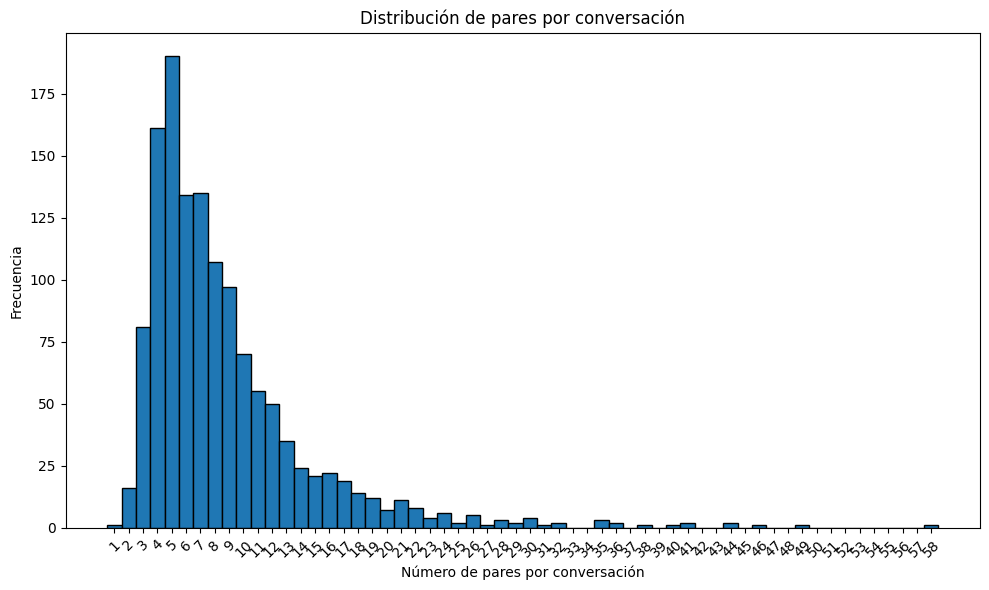

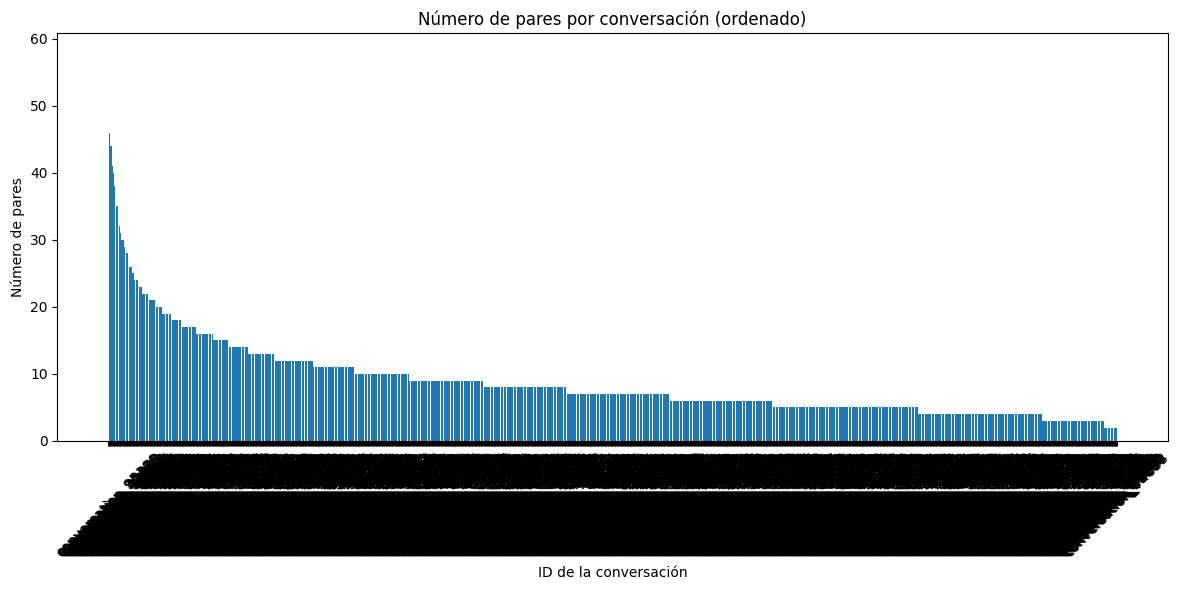

Error al decodificar JSON en el archivo pairs_extracted_with_context\conversation_94192\pair_2.json. Se omite este archivo.


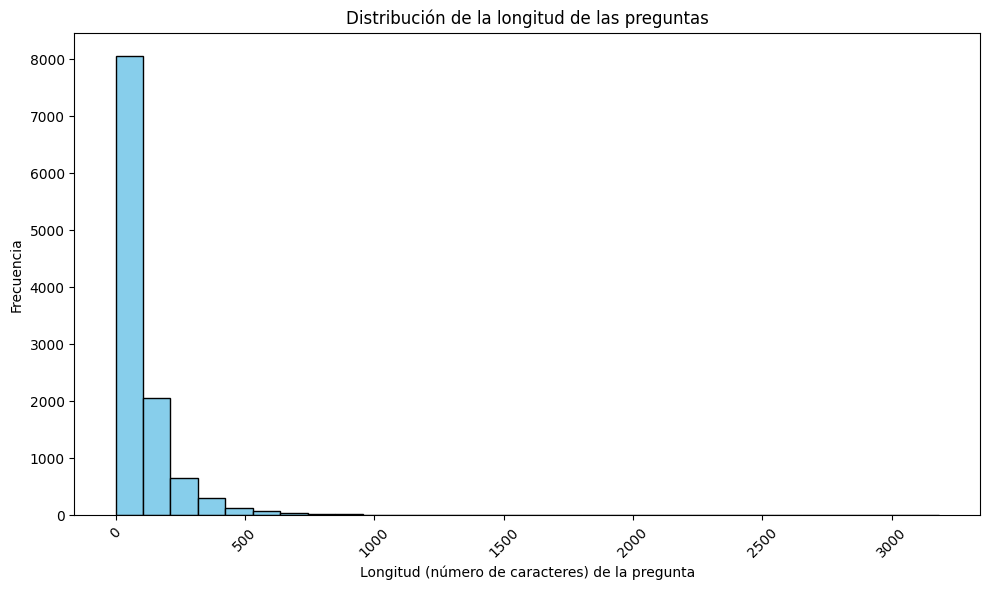

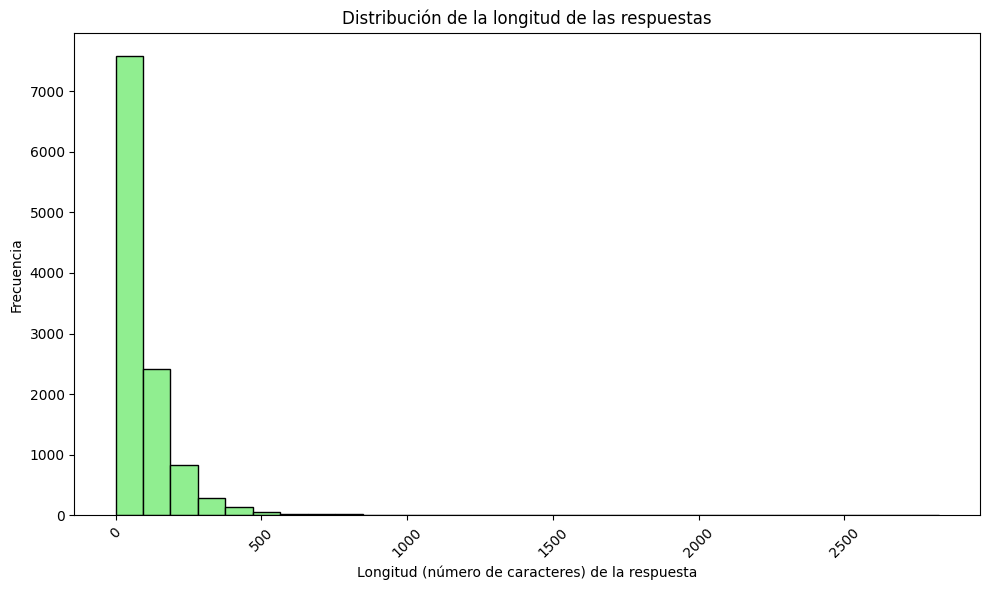

In [1]:
import os
import json
import matplotlib.pyplot as plt
import pandas as pd

# Define la carpeta raíz donde se encuentran las conversaciones extraídas.
root_folder = "pairs_extracted_with_context"

# Inicializar listas para almacenar el identificador de la conversación y el número de pares.
conversation_ids = []
pairs_counts = []

# Recorre cada subcarpeta (cada conversación)
for folder in os.listdir(root_folder):
    folder_path = os.path.join(root_folder, folder)
    if os.path.isdir(folder_path):
        conversation_ids.append(folder)
        # Contar todos los archivos JSON (pares) en la subcarpeta
        json_files = [f for f in os.listdir(folder_path) if f.endswith('.json')]
        pairs_counts.append(len(json_files))

# Calcular métricas generales
total_conversations = len(conversation_ids)
total_pairs = sum(pairs_counts)
average_pairs = total_pairs / total_conversations if total_conversations > 0 else 0
min_pairs = min(pairs_counts) if pairs_counts else 0
max_pairs = max(pairs_counts) if pairs_counts else 0

print("Métricas de la extracción:")
print("---------------------------")
print(f"Total de conversaciones extraídas: {total_conversations}")
print(f"Total de pares extraídos: {total_pairs}")
print(f"Promedio de pares por conversación: {average_pairs:.2f}")
print(f"Pares mínimos en una conversación: {min_pairs}")
print(f"Pares máximos en una conversación: {max_pairs}")

# Graficar la distribución de pares por conversación (histograma)
plt.figure(figsize=(10,6))
bins = range(1, max(pairs_counts) + 2)  # Cada número posible de pares
plt.hist(pairs_counts, bins=bins, align='left', edgecolor='black')
plt.xlabel("Número de pares por conversación")
plt.ylabel("Frecuencia")
plt.title("Distribución de pares por conversación")
plt.xticks(range(1, max(pairs_counts)+1), rotation=45)
plt.tight_layout()
plt.show()

# Crear un DataFrame con la información para graficar por conversación
df_pairs = pd.DataFrame({
    "conversation_id": conversation_ids,
    "pairs": pairs_counts
}).sort_values(by="pairs", ascending=False)

plt.figure(figsize=(12,6))
plt.bar(df_pairs["conversation_id"], df_pairs["pairs"])
plt.xlabel("ID de la conversación")
plt.ylabel("Número de pares")
plt.title("Número de pares por conversación (ordenado)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Métrica adicional: Distribución de la longitud de las preguntas y respuestas
questions_lengths = []
answers_lengths = []

# Recorrer cada archivo JSON para extraer la longitud de los campos 'question' y 'answer'
for conv_folder in conversation_ids:
    folder_path = os.path.join(root_folder, conv_folder)
    for file in os.listdir(folder_path):
        if file.endswith('.json'):
            file_path = os.path.join(folder_path, file)
            try:
                with open(file_path, "r", encoding="utf-8") as f:
                    data = json.load(f)
                questions_lengths.append(len(data.get("question", "")))
                answers_lengths.append(len(data.get("answer", "")) if data.get("answer") else 0)
            except json.JSONDecodeError:
                print(f"Error al decodificar JSON en el archivo {file_path}. Se omite este archivo.")
                continue

# Distribución de la longitud de las preguntas
plt.figure(figsize=(10,6))
plt.hist(questions_lengths, bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Longitud (número de caracteres) de la pregunta")
plt.ylabel("Frecuencia")
plt.title("Distribución de la longitud de las preguntas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Distribución de la longitud de las respuestas
plt.figure(figsize=(10,6))
plt.hist(answers_lengths, bins=30, color='lightgreen', edgecolor='black')
plt.xlabel("Longitud (número de caracteres) de la respuesta")
plt.ylabel("Frecuencia")
plt.title("Distribución de la longitud de las respuestas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
